# IoT Sensor Fault Prediction Using Random Forest approach

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

from imblearn.over_sampling import SMOTE

import time
import warnings
warnings.filterwarnings("ignore")

#### The Original version of the dataset used in this project is published by: De Bruijn, B., Nguyen, T.A., Bucur, D. and Tei, K., 2016. Benchmark datasets for fault detection and classification in sensor data. In International Confererence on Sensor Networks (pp. 185-195).

In [4]:
Dataset = pd.read_csv('IoT_Sensor_Fault_data.csv')

## Data Preprocessing.

In [7]:
Dataset.head(1000)

,timestamp,mote_id,has_fault_type,temperature,light,fault_label_multi,fault_label_binary
0,'2004-02-29T00:00:00',19,0,18.9100,0.460,normal,normal
1,'2004-02-29T00:00:30',19,0,18.9104,0.460,normal,normal
2,'2004-02-29T00:01:00',19,0,18.9100,0.460,normal,normal
3,'2004-02-29T00:01:30',19,0,18.9100,0.460,normal,normal
4,'2004-02-29T00:02:00',19,0,18.9104,0.460,normal,normal
...,...,...,...,...,...,...,...
995,'2004-02-29T08:17:30',19,0,18.0700,578.496,normal,normal
996,'2004-02-29T08:18:00',19,0,18.1300,584.384,normal,normal
997,'2004-02-29T08:18:30',19,0,18.1900,590.272,normal,normal
998,'2004-02-29T08:19:00',19,0,18.2440,596.160,normal,normal


In [9]:
Dataset = Dataset.drop(columns=['has_fault_type', 'fault_label_binary'])

In [11]:
Dataset.shape

(403200, 5)

In [13]:
Dataset2 = Dataset.drop(columns=['timestamp'])

In [15]:
Dataset2.head(1000)

,mote_id,temperature,light,fault_label_multi
0,19,18.9100,0.460,normal
1,19,18.9104,0.460,normal
2,19,18.9100,0.460,normal
3,19,18.9100,0.460,normal
4,19,18.9104,0.460,normal
...,...,...,...,...
995,19,18.0700,578.496,normal
996,19,18.1300,584.384,normal
997,19,18.1900,590.272,normal
998,19,18.2440,596.160,normal


### Check missing values and nulls

In [18]:
#Check missing values 
missing_values_count= Dataset2.isnull().sum()
total_cells = np.product(Dataset2.shape)
total_missing = missing_values_count.sum()

print(f"Percentage of total missing cells in the data {(total_missing/total_cells) * 100}%")
print(Dataset2.isnull().sum())

Percentage of total missing cells in the data 0.0%
mote_id              0
temperature          0
light                0
fault_label_multi    0
dtype: int64


### Class instances

In [21]:
Dataset['fault_label_multi'].value_counts()

fault_label_multi
normal         345155
bias            20736
malfunction     20730
drift           13824
random           2755
Name: count, dtype: int64

<Axes: xlabel='fault_label_multi', ylabel='count'>

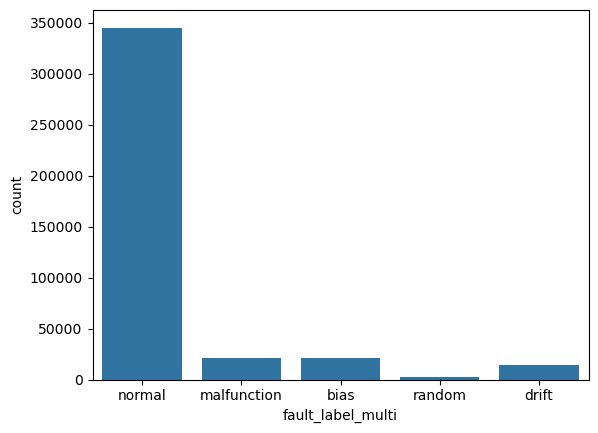

In [23]:
sns.countplot(x=Dataset['fault_label_multi'])

In [24]:
# Separating features (X) and target variables (Y)
X = Dataset2.drop(columns=['fault_label_multi'])
Y1 = Dataset2['fault_label_multi']

### Encoding

In [28]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y1)

### Splitting

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42,stratify=y_encoded)

### Scaling

In [34]:
# Scale (both train and test)
scaler_sensor = StandardScaler()
X_train = scaler_sensor.fit_transform(X_train)
X_test = scaler_sensor.transform(X_test)

### Balancing

In [37]:
# training set only
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [39]:
# Convert y_train_multi_smote to a pandas Series
y_train_smote_series = pd.Series(y_train)
y_train_smote_series = pd.Series(y_train)

print("Balanced Class Distribution (Training Set Only):")
print(y_train_smote_series.value_counts())
print()
print(y_train_smote_series.value_counts())

Balanced Class Distribution (Training Set Only):
3    276124
0    276124
1    276124
4    276124
2    276124
Name: count, dtype: int64

3    276124
0    276124
1    276124
4    276124
2    276124
Name: count, dtype: int64


## Training and testing

### Random Forest Model

In [43]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay,\
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix

In [45]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

==============================  Model performance against faults ==============================
              precision    recall  f1-score   support

        bias       0.99      1.00      0.99      4147
       drift       0.92      0.92      0.92      2765
 malfunction       0.65      0.80      0.72      4146
      normal       0.99      0.97      0.98     69031
      random       0.88      0.93      0.90       551

    accuracy                           0.96     80640
   macro avg       0.89      0.92      0.90     80640
weighted avg       0.97      0.96      0.97     80640

==============================  Model Overall Results ==============================

Model Accuracy:  0.9639
Model Precision: 0.8859
Model Recall:    0.9249
Model F1 Score:  0.9037



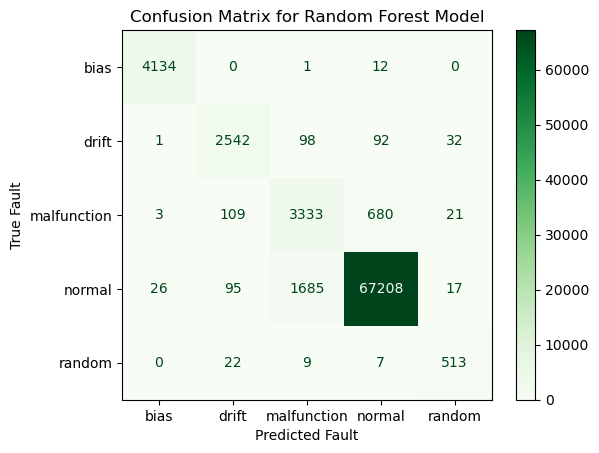

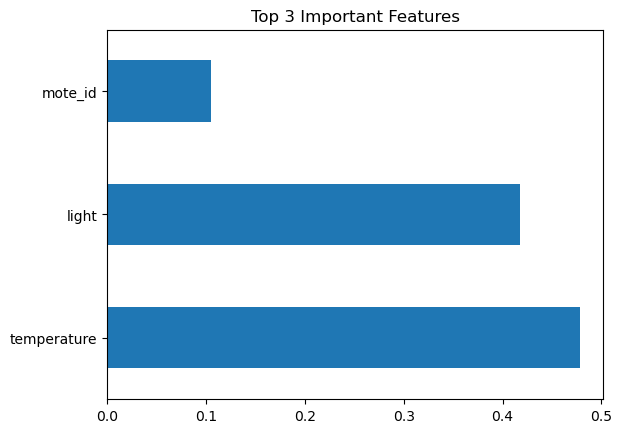

In [56]:
#Evalaution metrics
accuracy_test = accuracy_score(y_test,  y_pred)
precision_test = precision_score(y_test, y_pred, average = "macro")
recall_test = recall_score (y_test, y_pred, average = "macro")
F1_score_test = f1_score (y_test, y_pred, average = "macro")
cm = confusion_matrix(y_test, y_pred)

print('==============================  Model performance against faults ==============================')
print(classification_report(y_test, y_pred, target_names= label_encoder.classes_))

print('==============================  Model Overall Results ==============================')
print()
print(f"Model Accuracy:  {accuracy_test:.4f}")
print(f"Model Precision: {precision_test:.4f}")
print(f"Model Recall:    {recall_test:.4f}")
print(f"Model F1 Score:  {F1_score_test:.4f}")
print()
    
# Confusion matrix 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= label_encoder.classes_)
disp.plot(cmap=plt.cm.Greens)
plt.xlabel('Predicted Fault')
plt.ylabel('True Fault')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

print()
# Feature Importance
feature_importances = pd.Series(rf_model.feature_importances_,
                               index=X.columns)
feature_importances.nlargest(15).plot(kind='barh')
plt.title('Top 3 Important Features')
plt.show()